In [1]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.synapses import add_exp2
import time
%matplotlib inline
np.random.seed(123456789)


# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

# Function to get a random segment within a region of the dendrite
def randseg(region=None):
    tmp = np.random.uniform(0,1)
    if region is None:
        region = np.random.choice(['apic','dend_5','dend'])
    if region == 'apic':
        comp = h.apic[int(np.random.uniform(22,30))]
    elif region == 'dend_5':
        comp = h.dend_5[int(np.random.uniform(22,28))]
    elif region == 'dend':
        comp = h.dend[int(np.random.uniform(60,70))]
    return comp(tmp)

# Add a bunch of synapses
n_syn = 120
syn_rate = 50.0  # Hz
syndata = []
for i in range(n_syn): 
    spktimes = np.random.uniform(1,h.tstop-1,int(syn_rate*h.tstop/1e3))
    syndata.append(add_exp2(h,randseg(),spktimes,e=0,tau1=0.5,tau2=20,weight=0.001))

In [2]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
n = len(seg_list)

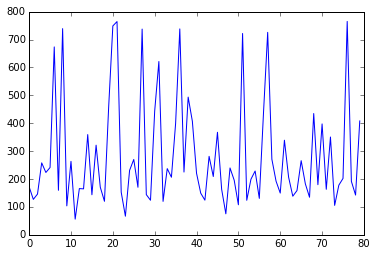

In [3]:
plt.figure()
leaf_dists = {}
for sec in sec_list:
    sref = h.SectionRef(sec=sec)
    if len(sref.child) == 0:
        leaf_dists[dist_to_soma(sec(0.5))] = sec

plt.plot(leaf_dists.keys())
plt.show()

In [4]:
max_dist = max(leaf_dists.keys())

# find primary neurite sections
primary = []
sref = h.SectionRef(sec=leaf_dists[max_dist])
while sref.has_parent():
    primary.append(sref.sec)
    sref = h.SectionRef(sec=sref.parent)

# find segments in primary neurite
primary_sec = np.zeros(len(sec_list),dtype=bool)
for (i,sec1) in enumerate(sec_list):
    for sec2 in primary:
        if sec1 == sec2 and i < 61:
            primary_sec[i] = 1

primary_segs = []
for (i,sec) in enumerate(sec_list):
    for seg in range(sec.nseg):
        primary_segs.append(primary_sec[i])

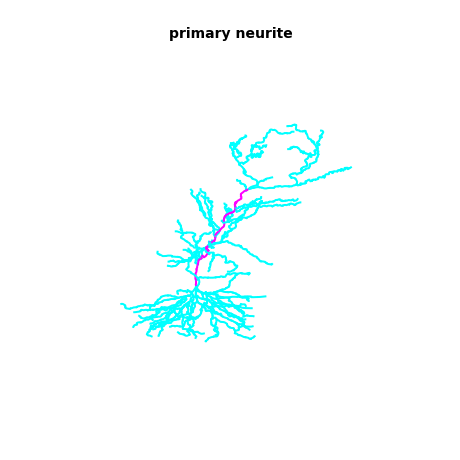

In [5]:
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
lines = shapeplot(h,shapeax,cvals=primary_segs,\
                  cmap=plt.cm.cool,order='pre',lw=2)
shapeax.view_init(elev=80,azim=-90)
plt.axis('off')
plt.title('primary neurite',fontweight='bold',fontsize=14)

In [6]:
(v,v_labels) = ez_record(h,order='pre')
h.finitialize() # has to come after ez_record

start_time = time.time()
while h.t < h.tstop:
    h.fadvance()
elapsed_time = time.time() - start_time

v = ez_convert(v)
t = np.linspace(0,h.t,v.shape[0])
v_avg = np.mean(v,axis=0)

In [7]:
def sushi_system(a,b,c,d):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for the degradation of u* is given by the vector "d"
    """
    # number of compartments
    N = len(d)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -d[i]
    
    return A

In [8]:
n = len(v_avg)

def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,Ctau=1e-3):
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = (1/(1+x))
    a = list(a)
    b = list((1/(1+x**-1)))
    d = list(np.zeros(n))#list(np.ones(n)*1e-7)
    c = list(Ctau*utarg/(F*utarg + (1-F)*K))
    A = sushi_system(a,b,c,d)
    return A

In [9]:
# Target spatial distribution:
utarg = (v_avg-np.min(v_avg))/(np.max(v_avg)-np.min(v_avg))*0.9 + 0.1
print len(utarg)

# matrix exponential used to solve linear system
from scipy.linalg import expm

# sparse matrix exponential
import scipy.sparse.linalg as sparse

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*n)
u0[0] = sum(utarg)  # compartment 0 is the soma

742


In [10]:
def solve_u(w,V,Vinv,t):
    D = np.diag(np.exp(w*t))          # diagonal matrix exponential
    PHI = np.real(V.dot(D.dot(Vinv))) # state transition matrix
    return PHI.dot(u0)                # calculate u(t)

def run_sim(A,nframes=2):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    t = np.logspace(-0.5,8.5,nframes)
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,8.5,nframes)
    for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))
    return np.array(utrace).T

def animate_sim(climits=[0,0.9]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('distribution of active/detached cargo',fontweight='bold',fontsize=14)
    plt.axis('off')

    # Hack to get a colorbar
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(climits[0],climits[1])) 
    sm._A = []
    plt.colorbar(sm, shrink=0.5)
    plt.tight_layout()

    anim_func = shapeplot_animate(u.T,lines,u.shape[1],clim=climits,cmap=cm.cool)
    return animation.FuncAnimation(fig, anim_func, frames=u.shape[1], interval=1e2, blit=True)

def snap_ss(name,clim=[0,0.9]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    sm._A = []
    plt.colorbar(sm, shrink=0.5)
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(name+'.svg')

First Case: timescales separated ($c_i$ small), little interference/competition
-----


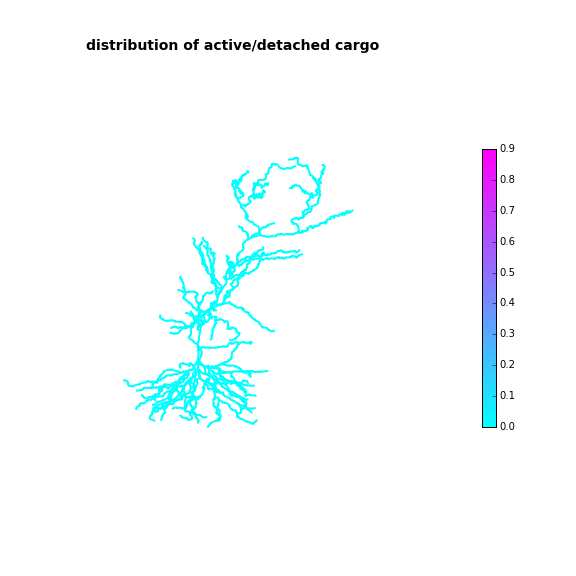
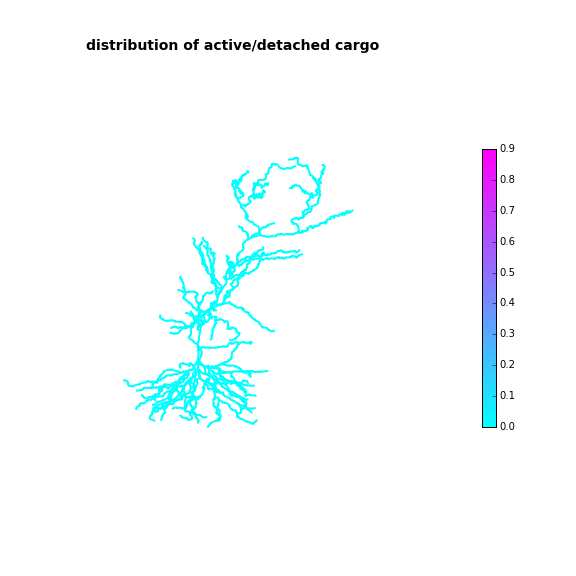
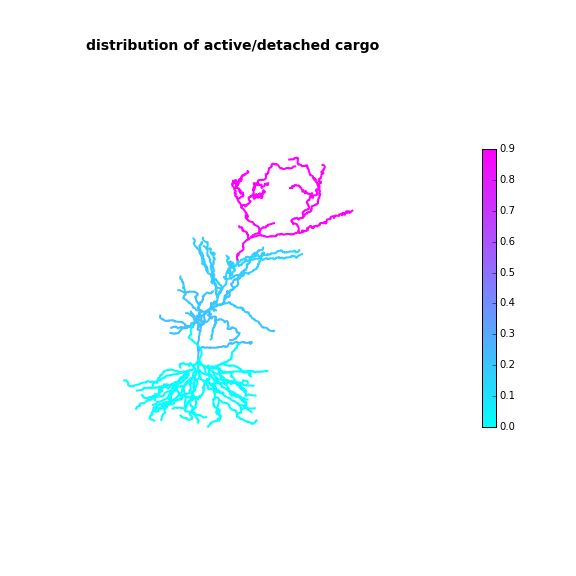

In [11]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 1e-3 # no trafficking to basal dend
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-5)
utrace = run_sim(A)

# animation
animate_sim()


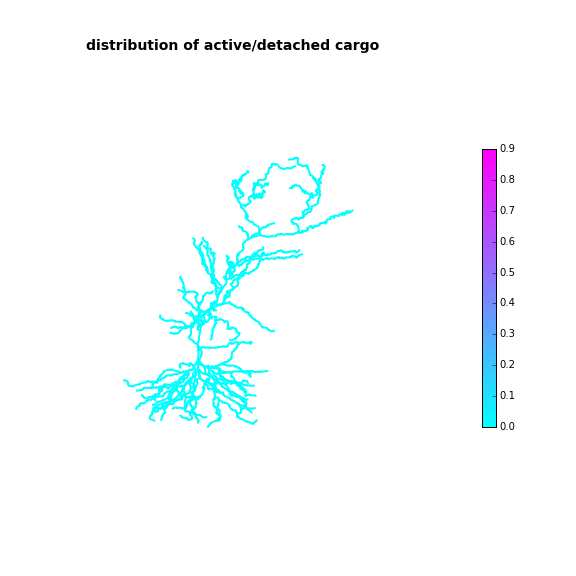
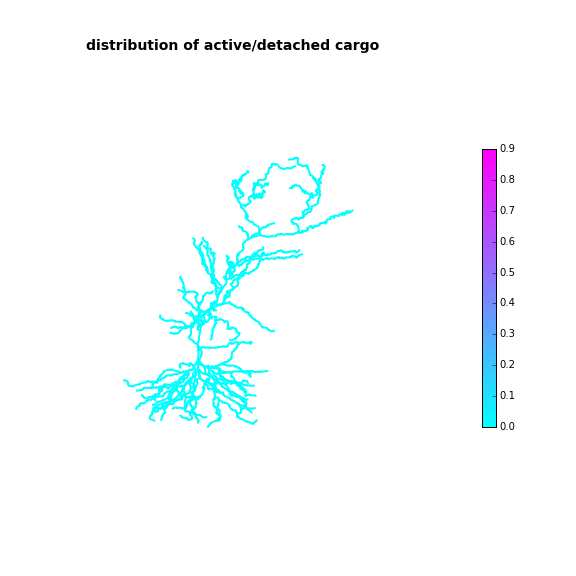
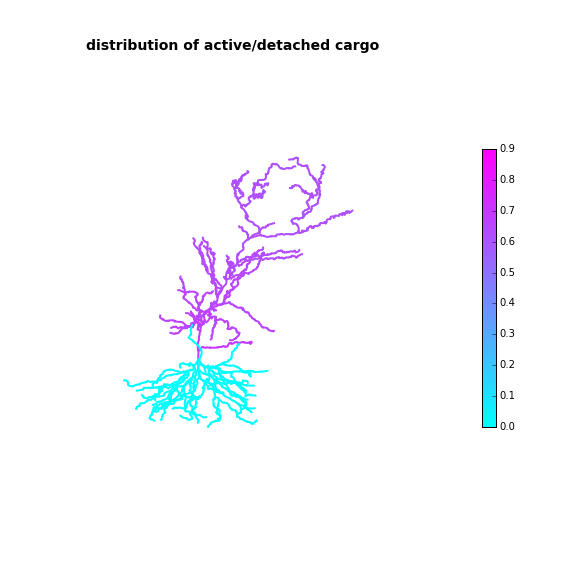

In [12]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 1e-3 # no trafficking to basal dend
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-5)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('1b')

# animation
animate_sim()

Second Case: timescales not separated, proximal inputs are *greedy* and prevent distal transport
----


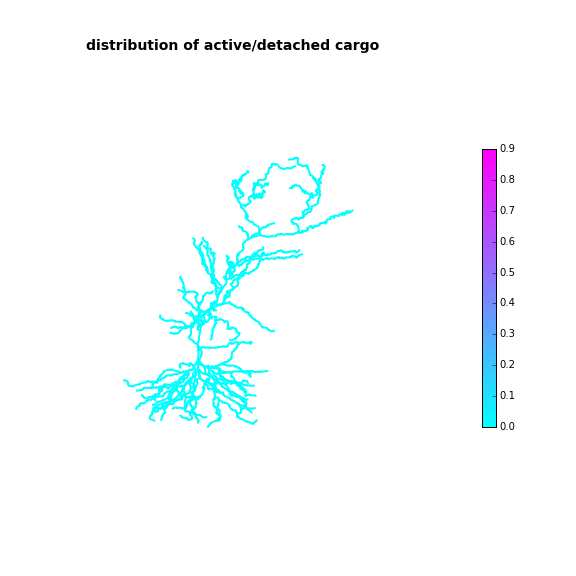
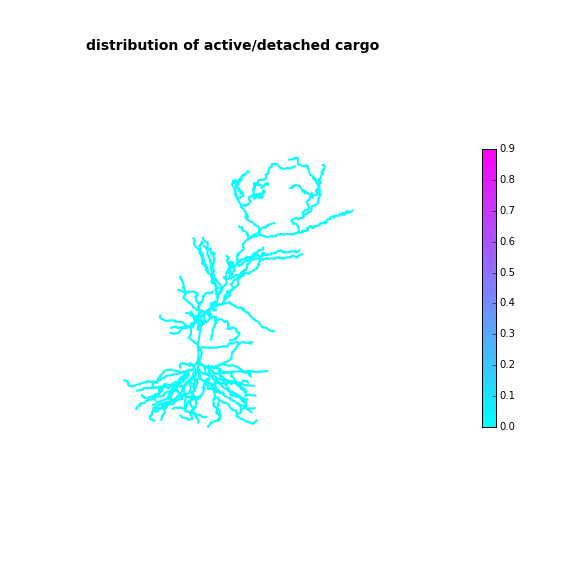
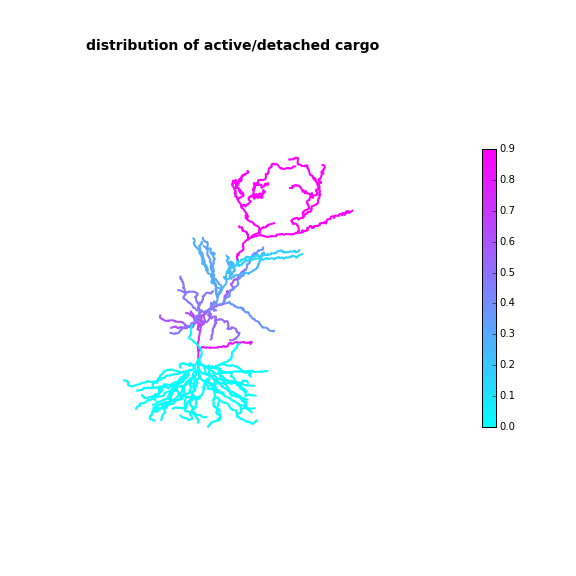

In [13]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('2a')

# animation
animate_sim()


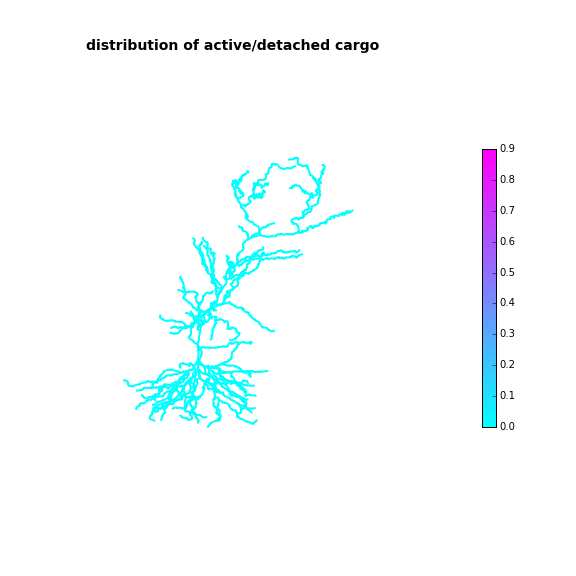
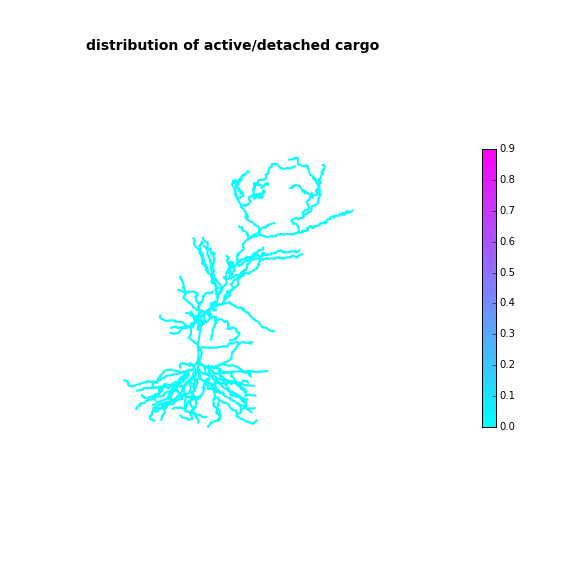
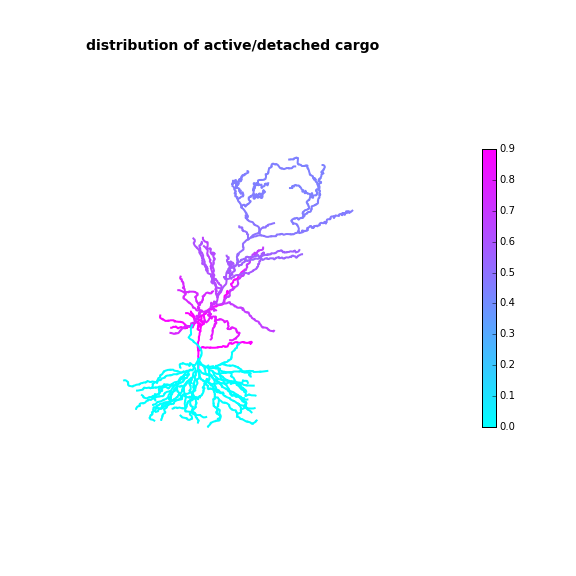

In [14]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('2b')

# animation
animate_sim()

Third Case: Time scales separated, different trafficking strategy
------


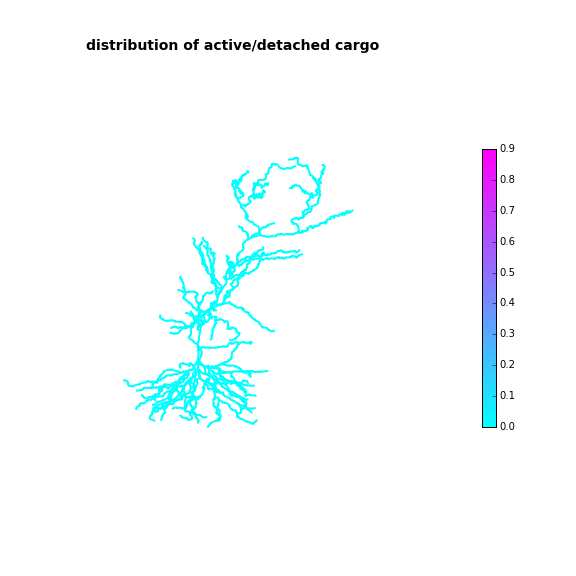
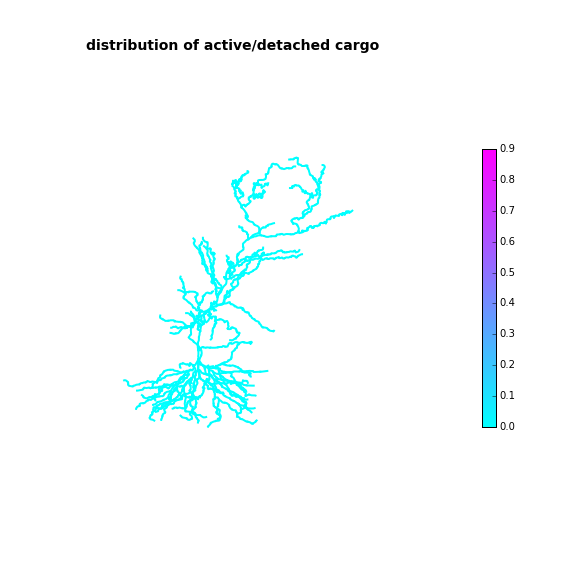
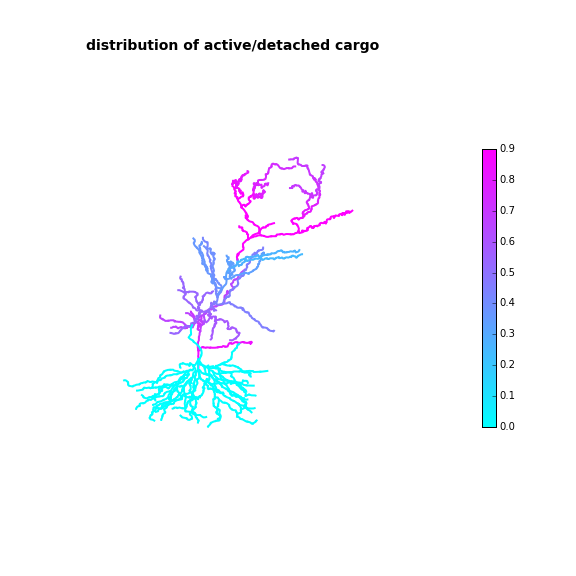

In [15]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=2e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('3a')

# animation
animate_sim()


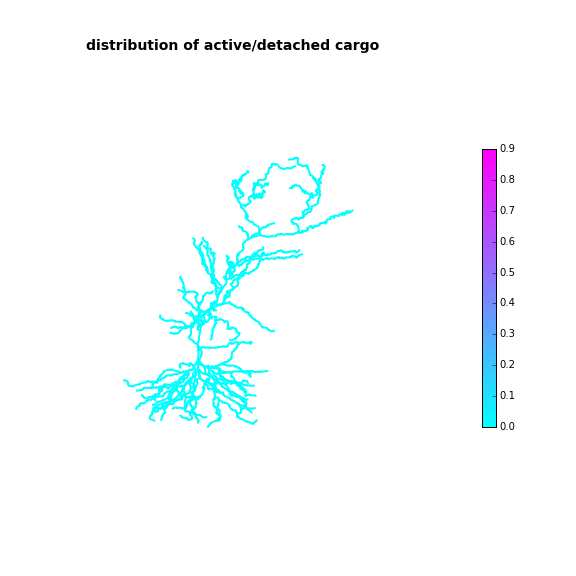
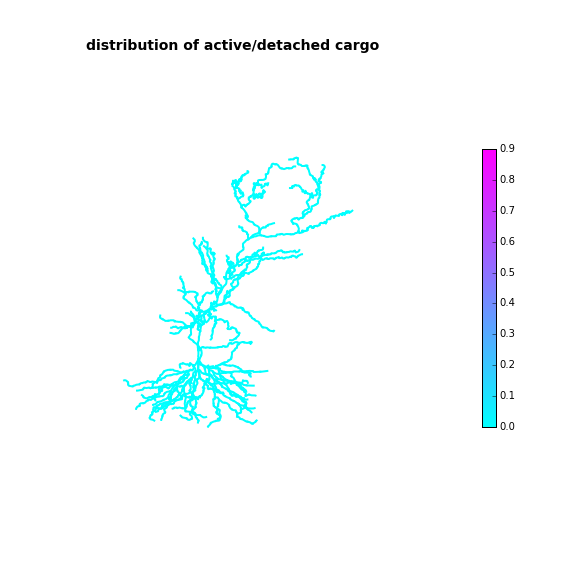
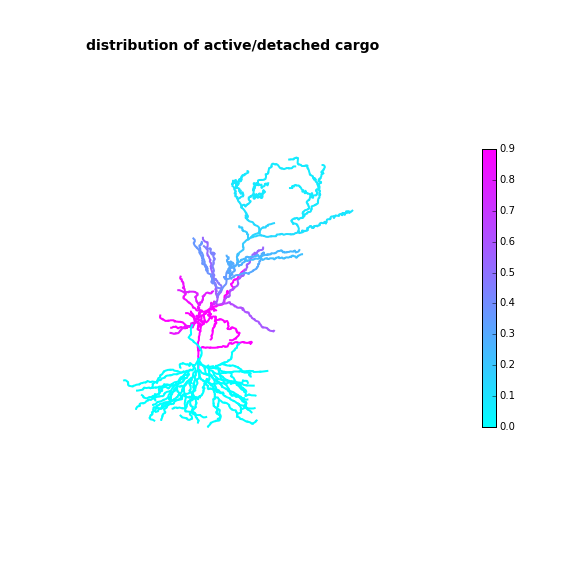

In [16]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=5e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('3b')

# animation
animate_sim()


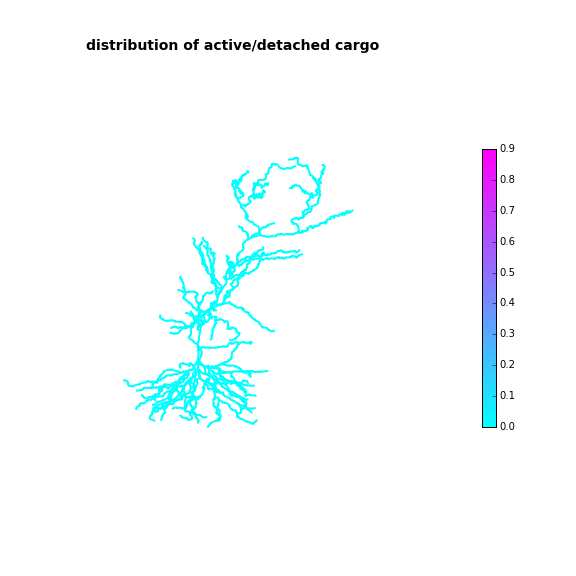
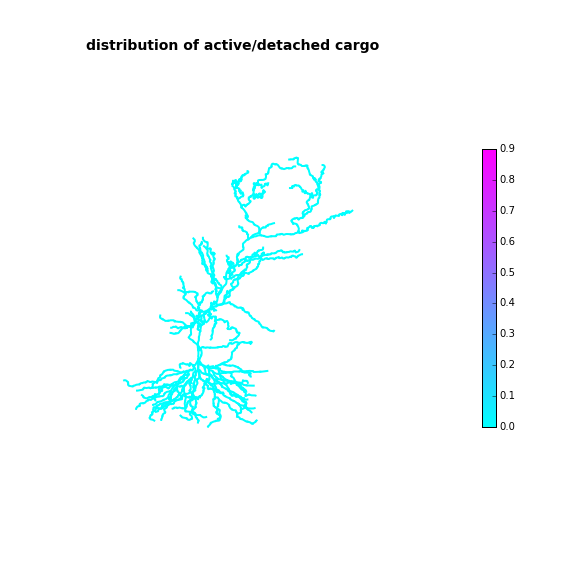
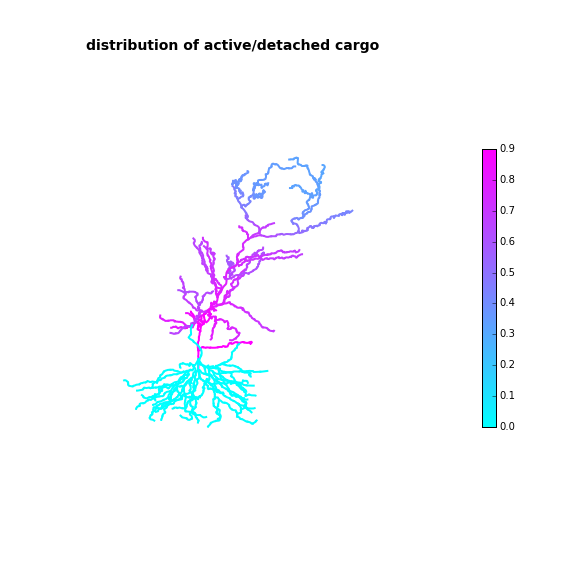

In [17]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=5e-4)
ind = np.argwhere(primary_segs).T[0]
for p in ind:
    for c in ind:
        if A[c,p] > 0:
            A[c,p] += 10
            A[p,p] -= 10

utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('3b')

# animation
animate_sim()


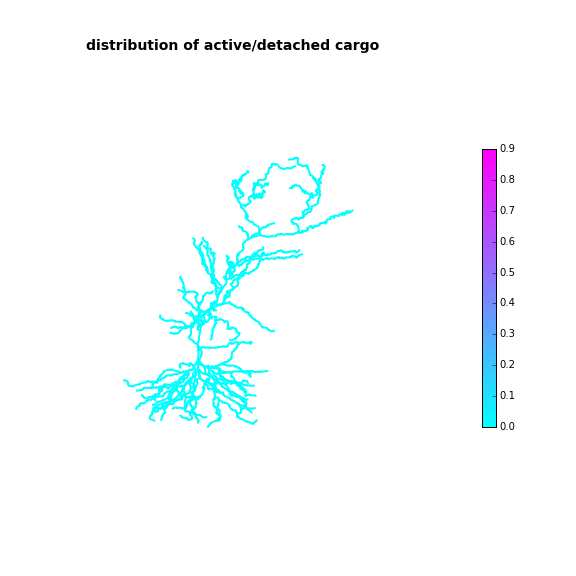
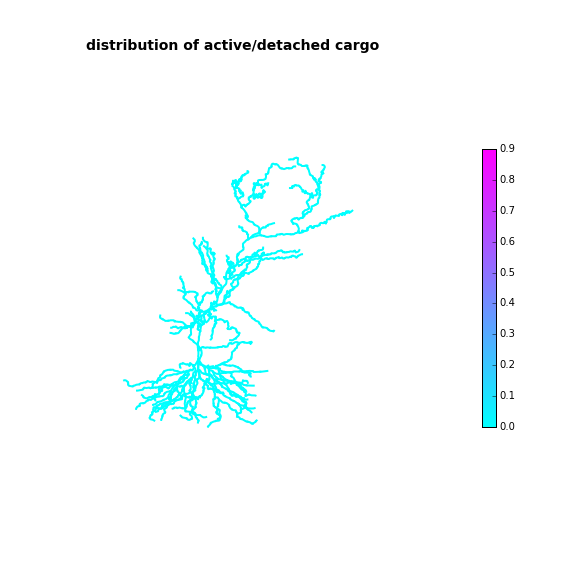
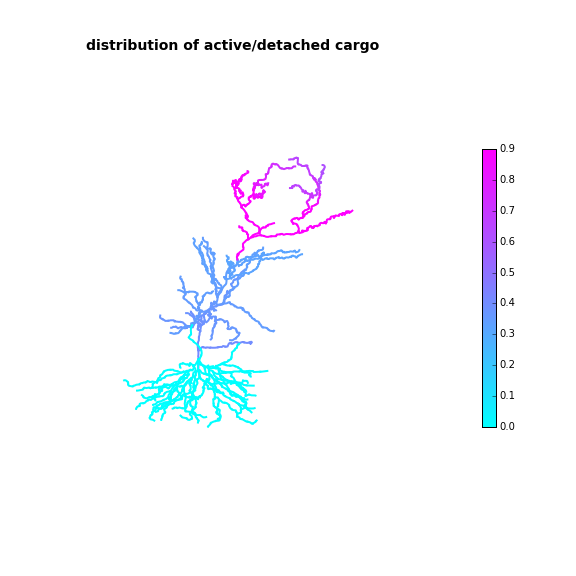

In [18]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=5e-4)
ind = np.argwhere(primary_segs).T[0]
for p in ind:
    for c in ind:
        if A[c,p] > 0:
            A[c,p] += 10
            A[p,p] -= 10

utrace = run_sim(A)

# animation
animate_sim()


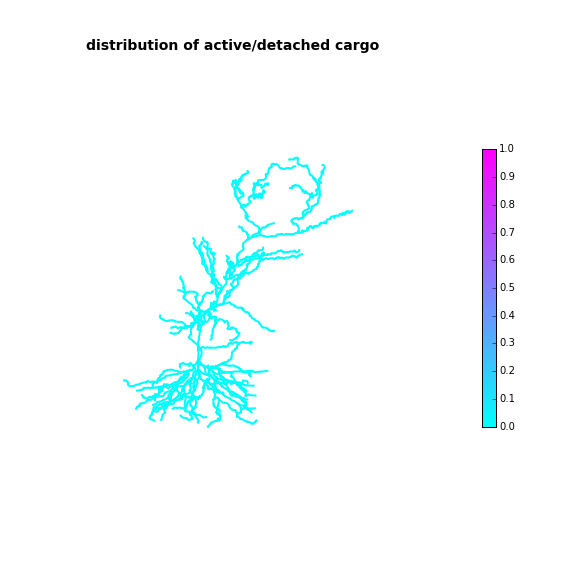
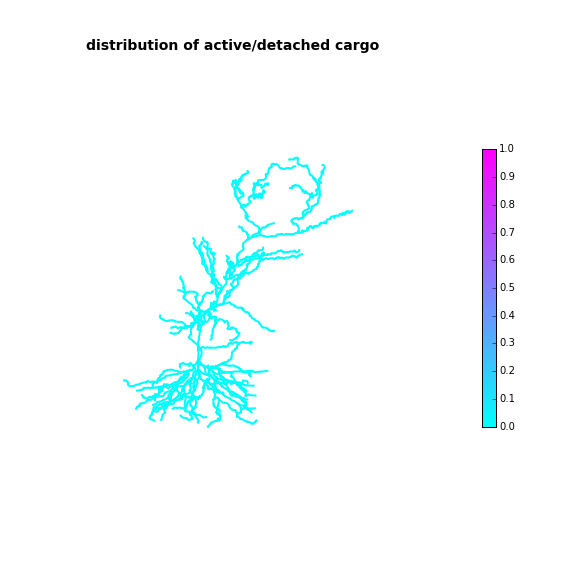
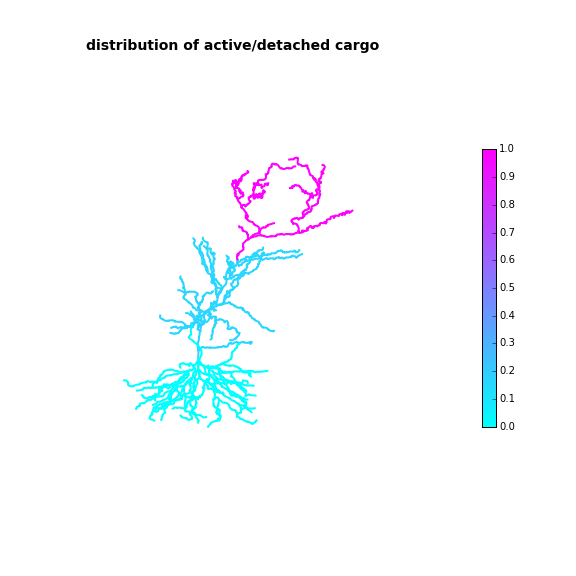

In [19]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Add bias along primary neurite
A = get_sys_matrix(utarg,F=0,Ctau=1e-5)
ind = np.argwhere(primary_segs).T[0]
for p in ind:
    for c in ind:
        if A[c,p] > 0:
            A[c,p] += 1000
            A[p,p] -= 1000

# Run simulation
utrace = run_sim(A)

# animation
animate_sim(climits=[0,1])